In [1]:
import numpy as np
import matplotlib.pyplot as plt

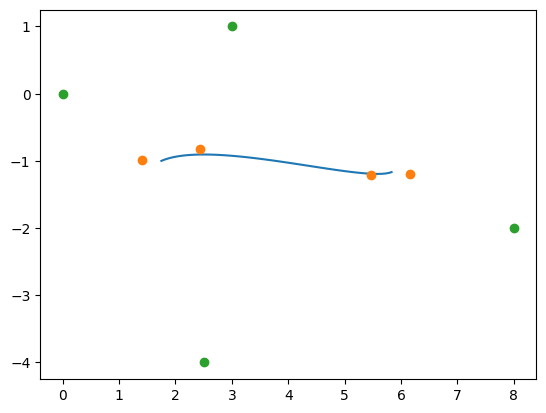

In [86]:
#create the basis coefficient matrices
#spline types: Bezier, BSpline, Catmull-Rom
#create a json file to store the basis matrices for each of the above splines

#original minvo from the paper which works for t values of -1  to 1
minvo3 = np.array([
    [-0.4302, 0.4568, -0.02698, 0.0004103],
    [0.8349, -0.4568, -0.7921, 0.4997],
    [-0.8349, -0.4568, 0.7921, 0.4996],
    [0.4302, 0.4568, 0.02698, -0.0004103]
]).T

#modified minvo to work with t from 0 to 1 like most other splines
minvo3 = np.array([
    [-3.4416, 6.9896, -4.46236, 0.91439], 
    [6.6792, -11.846, 5.2524, 0.0001],
    [-6.6792, 8.1916, -1.598, 0.0856],
    [3.4416, -3.3352, 0.80796, -0.0007903]
]).T

# t = -1
# print(np.array([t**3, t**2, t, 1])@minvo3)
# t = 0
# print(np.array([t**3, t**2, t, 1])@minvo3_1)
bezier3 = np.array([
    [-1, 3, -3, 1],
    [3, -6, 3, 0], 
    [-3, 3, 0, 0],
    [1, 0, 0, 0]])

bspline3 = np.array([
    [-1, 3, -3, 1],
    [3, -6, 3, 0],
    [-3, 0, 3, 0],
    [1, 4, 1, 0]]) / 6
#random four points in space
points = np.array([[0,0], [1,1], [2,0], [3,2]])
points = np. array([[3,1],[8,-2],[0,0],[2.5,-4]])

def draw_spline(t:float):
    # print(t)
    T = np.array([t**3, t**2, t, 1])
    MP = bspline3@points
    P = T@MP
    return P

t_values = np.linspace(0, 1, 100)
spline_points = np.array([draw_spline(t) for t in t_values])
plt.plot(spline_points[:,0], spline_points[:,1])
minvo_points = np.linalg.inv(minvo3)@bspline3@points
plt.plot(minvo_points[:, 0], minvo_points[:, 1], 'o')
plt.plot(points[:, 0], points[:, 1], 'o')


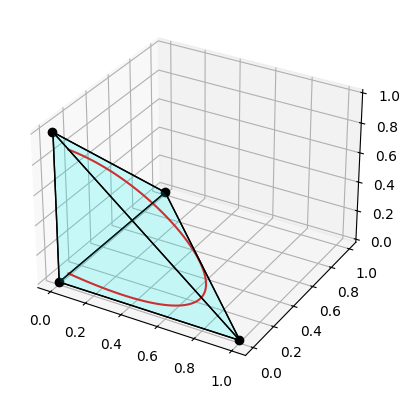

In [62]:
#create the basis coefficient matrices
#spline types: Bezier, BSpline, Catmull-Rom
#create a json file to store the basis matrices for each of the above splines
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#random four points in space
points = np.array([[0,0,0], [1,0,0], [0,1,0], [0,0,1]])

def draw_spline(t:float):
    # print(t)
    T = np.array([t**3, t**2, t, 1])
    MP = minvo3@points
    P = T@MP
    return P

t_values = np.linspace(-1, 1, 100)
spline_points = np.array([draw_spline(t) for t in t_values])
hull = ConvexHull(points)
ax = plt.figure().add_subplot(projection='3d')
for simplex in hull.simplices:
    # Extract the vertices for each simplex (face of the tetrahedron)
    simplex = np.append(simplex, simplex[0])  # loop back to first vertex
    # Fill the face with a translucent color
    triangle = points[simplex[:3]]
    ax.add_collection3d(Poly3DCollection([triangle], ec = 'k', fc='cyan', alpha=0.1))  # adjust alpha for translucency
ax.plot(spline_points[:,0], spline_points[:,1],spline_points[:,2], color = 'r')
ax.plot(points[:, 0], points[:, 1], points[:, 2], 'ko')
plt.show()

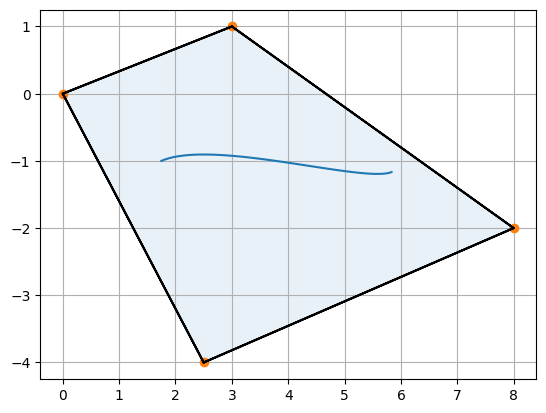

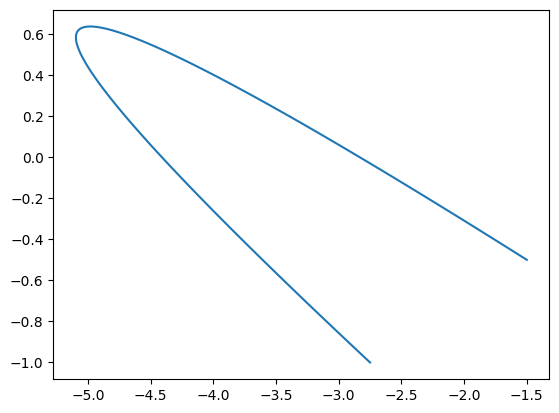

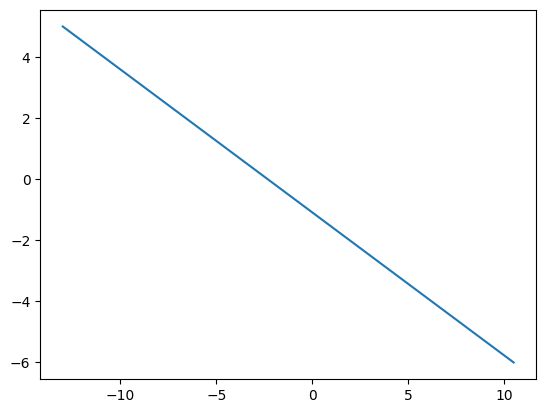

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from typing import Literal
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots()
basis = minvo3

def polynomial_matrix(t_values, max_degree):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def derivative_matrix(poly_matrix):
    # Get the number of columns (max_degree + 1)
    max_degree = poly_matrix.shape[1] - 1
    # Create the derivative matrix
    derivatives = np.zeros_like(poly_matrix)
    for i in range(max_degree):
        # Derivative of t^degree is degree*t^(degree-1)
        degree = max_degree - i
        derivatives[:, i] = degree * poly_matrix[:, i+1]
    # The last column (constant term) derivative is zero and already initialized
    return derivatives


# Assuming the points array is extended to multiple segments
def draw_connected_splines(points, basis:str):
    num_segments = (len(points) - 1) // 3
    if basis in {'bernstein', 'bezier'}:
        basis = bezier3
    elif basis == 'bspline':
        basis = bspline3
    else:
        basis = minvo3
    t_values = np.linspace(0, 1, 100)
    all_spline_points = []
    all_velocity_points = []
    all_acceleration_points = []
    hulls = []
    for i in range(num_segments):
        segment_points = points[3*i:3*i+4]  # Select the 4 control points for the current segment
        # print(segment_points)
        T = polynomial_matrix(t_values, max_degree= basis.shape[0] - 1)
        spline_points = T@basis@segment_points
        Tvel = derivative_matrix(T)
        velocity_points = Tvel@basis@segment_points
        Tacc = derivative_matrix(Tvel)
        acceleration_points = Tacc@basis@segment_points
        all_spline_points.append(spline_points)
        all_velocity_points.append(velocity_points)
        all_acceleration_points.append(acceleration_points)
        # print(f"{segment_points =}")
        hulls.append(ConvexHull(segment_points))
        # print(segment_points)
        

    for spline_points in all_spline_points:
        plt.plot(spline_points[:, 0], spline_points[:, 1])

    plt.plot(points[:, 0], points[:, 1], 'o')  # Plot all control points

    for idx, hull in enumerate(hulls):
        n = (hull.vertices.shape[0]-1)
        for simplex in hull.simplices:
            # Loop back to the first vertex to close the polygon
            simplex = np.append(simplex, simplex[0])+idx*n
            # print(f"{simplex=}")
            ax.plot(points[simplex, 0], points[simplex, 1], 'k-')  # Black edge color

            # Fill the polygon with a translucent color
            # verts = np.array([[0,0], [1,0],[1,1]])
            # print(hull.vertices, "hi")
        polygon = plt.Polygon(points[hull.vertices+idx*n], closed=True, alpha=0.1, edgecolor='magenta')
        # print(type(points[simplex]),points[simplex], polygon.get_verts())
        ax.add_patch(polygon)
            # print(ax.patches)

    plt.grid(True)
    plt.show()

    for velocity_points in all_velocity_points:
        plt.plot(velocity_points[:, 0], velocity_points[:, 1])

    plt.show()

    for acceleration_points in all_acceleration_points:
        plt.plot(acceleration_points[:, 0], acceleration_points[:, 1])
    plt.show()
# Example control points
points = np.array([[0,0], [1,1], [2,0], [3,2], [4,4], [5.2,3], [6,0],[6.8,-3], [8,0], [9.5,-2]])
points = np.array([[3,1],[8,-2],[0,0],[2.5,-4]])
# points = np.array([[3,2], [4,4], [5.2,3], [6,0]])

draw_connected_splines(points, 'bspline')




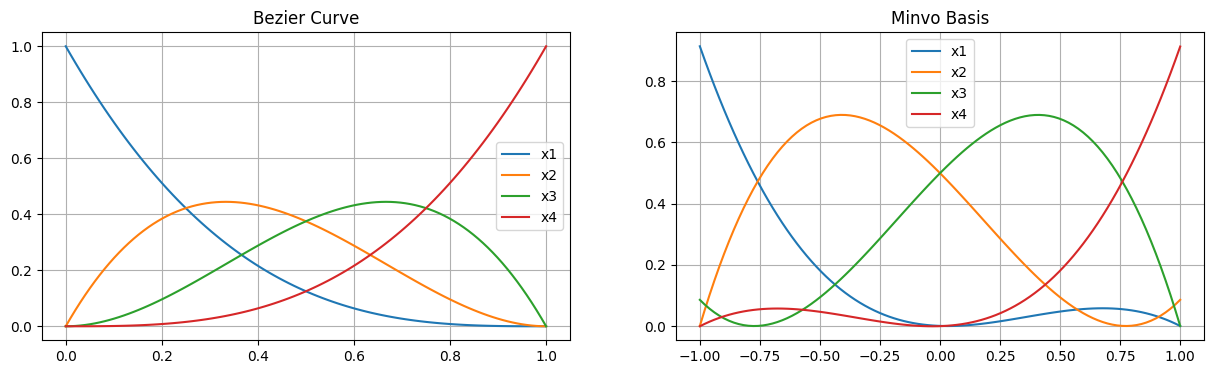

In [284]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))  # 10 inches wide, 4 inches tall

# First plot
ts = np.linspace(0, 1, 100)
T = polynomial_matrix(ts, 3)
ys = T @ bezier3

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(ts, ys)
plt.grid(True)
plt.legend(['x1', 'x2', 'x3', 'x4'])
plt.title('Bezier Curve')

# Second plot
ts = np.linspace(-1, 1, 100)
T = polynomial_matrix(ts, 3)
ys = T @ minvo3

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(ts, ys)
plt.grid(True)
plt.legend(['x1', 'x2', 'x3', 'x4'])
plt.title('Minvo Basis')

# Show the plots
plt.show()

In [223]:
''' 
Can you introduce yourself?
-- Adrian: Im adrian research engineer ENAC AIRBUS SOPRA STERIA Drones and UTM Research Chair
 What are you working on?
-- Adrian: Deconfliction, ensuring drones don't collide. Show simulation
 What is the relationship between these examples and the ATM-UTM domain?
-- Adrian: combining robotics automatic deconfliction and human air traffic into a hyprid service system + details (ie sold as a service)
Are there any other topics you are working on?
-- Adrian: The group is working on a holistic simulator of a UTM environment. I contribute various services to this simulator, such as strategic and tactical deconfliction for the UTM traffic in the simulator. We also try to leverage any available tools to improve our research, such as learning or data based approaches. 
'''


" \nCan you introduce yourself?\n-- Adrian: Im adrian research engineer ENAC AIRBUS SOPRA STERIA Drones and UTM Research Chair\n What are you working on?\n-- Adrian: Deconfliction, ensuring drones don't collide. Show simulation\n What is the relationship between these examples and the ATM-UTM domain?\n-- Adrian: combining robotics automatic deconfliction and human air traffic into a hyprid service system + details (ie sold as a service)\nAre there any other topics you are working on?\n-- Adrian: The group is working on a holistic simulator of a UTM environment. I contribute various services to this simulator, such as strategic and tactical deconfliction for the UTM traffic in the simulator. We also try to leverage any available tools to improve our research, such as learning or data based approaches. \n"

In [236]:
from numpy.typing import ArrayLike
def create_t_matrix(t_values:ArrayLike, max_degree:int):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    terms = [np.array(t_values)**i for i in range(max_degree, -1, -1)]
    return np.vstack(terms).T

create_t_matrix(np.array([1,2,3]), 3)

array([[ 1,  1,  1,  1],
       [ 8,  4,  2,  1],
       [27,  9,  3,  1]])

In [239]:
import numpy as np

def polynomial_matrix(t_values, max_degree):
    # Create an array from t^max_degree to t^1, and include an array of 1s for t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def derivative_matrix(poly_matrix):
    # Get the number of columns (max_degree + 1)
    max_degree = poly_matrix.shape[1] - 1
    # Create the derivative matrix
    derivatives = np.zeros_like(poly_matrix)
    for i in range(max_degree):
        print(f"{i=}")
        # Derivative of t^degree is degree*t^(degree-1)
        degree = max_degree - i
        print(f"{degree=}")
        derivatives[:, i] = degree * poly_matrix[:, i+1]
    # The last column (constant term) derivative is zero and already initialized
    return derivatives

# Example usage:
t_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
max_degree = 3
poly_mat = polynomial_matrix(t_values, max_degree)
deriv_mat = derivative_matrix(poly_mat)

print("Polynomial Matrix:\n", poly_mat)
print("Derivative Matrix:\n", deriv_mat)


i=0
degree=3
i=1
degree=2
i=2
degree=1
Polynomial Matrix:
 [[   1    1    1    1]
 [   8    4    2    1]
 [  27    9    3    1]
 [  64   16    4    1]
 [ 125   25    5    1]
 [ 216   36    6    1]
 [ 343   49    7    1]
 [ 512   64    8    1]
 [ 729   81    9    1]
 [1000  100   10    1]]
Derivative Matrix:
 [[  3   2   1   0]
 [ 12   4   1   0]
 [ 27   6   1   0]
 [ 48   8   1   0]
 [ 75  10   1   0]
 [108  12   1   0]
 [147  14   1   0]
 [192  16   1   0]
 [243  18   1   0]
 [300  20   1   0]]


In [242]:
import numpy as np

def polynomial_matrix(t_values, max_degree):
    # Generate a matrix of powers of t from t^max_degree to t^0
    return np.vstack([t_values**i for i in range(max_degree, -1, -1)]).T

def nth_derivative_matrix(poly_matrix, n):
    num_rows, num_cols = poly_matrix.shape
    derivatives = poly_matrix.copy()
    for _ in range(n):
        # Prepare a new matrix to store the next derivative
        new_derivatives = np.zeros_like(derivatives)
        for col in range(num_cols - 1):  # Last column is always zero after differentiation
            # The new column is the current column index multiplied by the next column in the derivative matrix
            new_derivatives[:, col] = (num_cols - col - 1) * derivatives[:, col + 1]
        # Update derivatives matrix
        derivatives = new_derivatives
    return derivatives

# Example usage:
t_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
max_degree = 3
n = 2  # Change this for different nth derivatives
poly_mat = polynomial_matrix(t_values, max_degree)
nth_deriv_mat = nth_derivative_matrix(poly_mat, n)

print("Polynomial Matrix:\n", poly_mat)
print(f"{n}th Derivative Matrix:\n", nth_deriv_mat)


Polynomial Matrix:
 [[   1    1    1    1]
 [   8    4    2    1]
 [  27    9    3    1]
 [  64   16    4    1]
 [ 125   25    5    1]
 [ 216   36    6    1]
 [ 343   49    7    1]
 [ 512   64    8    1]
 [ 729   81    9    1]
 [1000  100   10    1]]
2th Derivative Matrix:
 [[ 6  2  0  0]
 [12  2  0  0]
 [18  2  0  0]
 [24  2  0  0]
 [30  2  0  0]
 [36  2  0  0]
 [42  2  0  0]
 [48  2  0  0]
 [54  2  0  0]
 [60  2  0  0]]
